https://ourcodingclub.github.io/2018/12/10/topic-modelling-python.html#apply

In [1]:
# packages to store and manipulate data
import pandas as pd
import numpy as np

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# model building package
import sklearn

# package to clean text
import re

In [2]:
df = pd.read_csv('climate_tweets.csv')

In [3]:
df.sample(10)

,tweet
4868,"Global warming an Olympic worry, says Rogge|VA..."
4092,Police question global warming 'sceptic' scien...
862,-- Press Releases April 2010 - Climate change ...
905,Calif. Trucking Assn. joins fight to suspend s...
2641,RT @epsomguardian: Photo exhibition 2 highligh...
1185,RT @TreeHugger RT @huffpostgreen well this is ...
2977,RT @VRWCTexan: The great global warming collap...
109,RT @nicnunes: RT @EPSclimate: Indigenous tradi...
1713,Geological Society of America Position Stateme...
1344,reading from @time Allergies Worse Than Ever? ...


In [4]:
df.shape

(6090, 1)

In [5]:
df["tweet"].unique().shape

(5541,)

In [6]:
df['is_retweet'] = df['tweet'].apply(lambda x: x[:2]=='RT')
df['is_retweet'].sum()  # number of retweets

773

In [7]:
# 10 most repeated tweets
df.groupby(['tweet']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10)

,tweet,counts
3131,No matter if you believe in global warming or ...,20
4555,Take Action @change: Help Protect Wildlife Hab...,14
4027,RT @newtgingrich: Historic snow storm in washi...,9
1765,Fight Climate Change From All Fronts: [link],8
1626,Earth's polar ice sheets vulnerable to even mo...,7
1941,Global Warming Dent's El Ni'o's Protective Shi...,7
1799,Foes of California's global warming law pour m...,6
1351,Coalition of the Tired of Waiting: Fighting Cl...,6
4271,SCIENCE: Scientists explore the evolution of c...,6
1040,Carbon offsets: How a Vatican forest failed to...,6


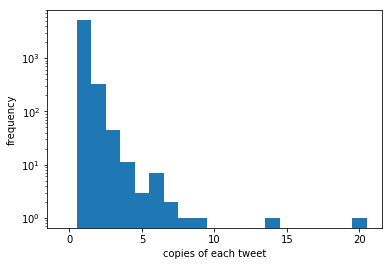

In [8]:
# number of times each tweet appears
counts = df.groupby(['tweet']).size().reset_index(name='counts').counts

# define bins for histogram
my_bins = np.arange(0,counts.max()+2, 1)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('copies of each tweet')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

In [9]:
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)   

In [10]:
# make new columns for retweeted usernames, mentioned usernames and hashtags
df['retweeted'] = df.tweet.apply(find_retweeted)
df['mentioned'] = df.tweet.apply(find_mentioned)
df['hashtags'] = df.tweet.apply(find_hashtags)

In [11]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = df.loc[
                       df.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

In [12]:
# create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

In [13]:
# number of unique hashtags
flattened_hashtags_df['hashtag'].unique().size

477

In [14]:
# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_hashtags.head()

,hashtag,counts
0,#tcot,227
1,#climate,202
2,#p2,112
3,#green,50
4,#climatechange,47


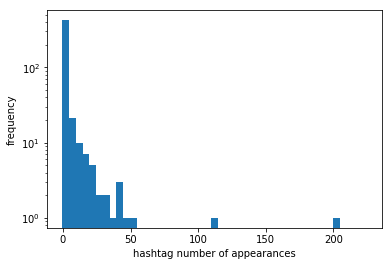

In [15]:
# number of times each hashtag appears
counts = flattened_hashtags_df.groupby(['hashtag']).size()\
                              .reset_index(name='counts')\
                              .counts

# define bins for histogram                              
my_bins = np.arange(0,counts.max()+2, 5)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('hashtag number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

In [16]:
# take hashtags which appear at least this amount of times
min_appearance = 10
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])
popular_hashtags_set

{'#Climate',
 '#EarthDay',
 '#FoxNews',
 '#GlobalWarming',
 '#Green',
 '#IPCC',
 '#News',
 '#SaveTerra',
 '#SierraClub',
 '#TCOT',
 '#UN',
 '#agw',
 '#cleantech',
 '#climate',
 '#climatechange',
 '#climategate',
 '#cochabamba',
 '#du1',
 '#earthday',
 '#eco',
 '#energy',
 '#environment',
 '#fb',
 '#global',
 '#globalwarming',
 '#gop',
 '#green',
 '#news',
 '#ocra',
 '#p2',
 '#sgp',
 '#snowpocalypse',
 '#tcot',
 '#teaparty',
 '#tlot'}

In [17]:
# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]

In [18]:
# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))
hashtag_vector_df

,popular_hashtags,#green,#agw,#climategate,#cochabamba,#IPCC,#EarthDay,#News,#environment,#news,...,#globalwarming,#FoxNews,#UN,#snowpocalypse,#fb,#TCOT,#climate,#Green,#gop,#global
12,[#Climate],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,[#EarthDay],0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,[#tcot],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,"[#ocra, #sgp, #gop, #tlot, #p2]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
39,"[#tcot, #p2]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,"[#IPCC, #teaparty]",0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,"[#global, #climate, #eco]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
137,[#climate],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
138,[#green],1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140,[#climate],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [19]:
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

In [20]:
# calculate the correlation matrix
correlations = hashtag_matrix.corr()

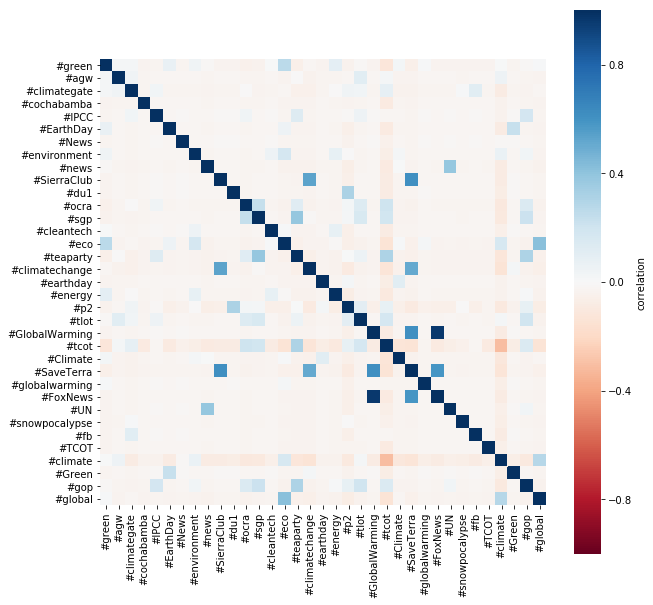

In [21]:
# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

----------

# Cleaning Unstructured Text Data

In [24]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [25]:
#downloading stop words in order to filter super common words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alonsoga\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [26]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [34]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [38]:
df['clean_tweet'] = df.tweet.apply(clean_tweet)
df.head()

,tweet,is_retweet,retweeted,mentioned,hashtags,clean_tweet
0,Global warming report urges governments to act...,False,[],[],[],global warm report urg govern act brussel belg...
1,Fighting poverty and global warming in Africa ...,False,[],[],[],fight poverti global warm africa
2,Carbon offsets: How a Vatican forest failed to...,False,[],[],[],carbon offset vatican forest fail reduc global...
3,Carbon offsets: How a Vatican forest failed to...,False,[],[],[],carbon offset vatican forest fail reduc global...
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,False,[],[],[],uruguay tool need vulner climat chang


----------

# Applying Topic Modelling

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df['clean_tweet']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

In [41]:
tf.shape #tweets and words

(6090, 425)

In [42]:
tf_feature_names #words

['#climate',
 '#climatechange',
 '#climategate',
 '#earthday',
 '#eco',
 '#energy',
 '#global',
 '#globalwarming',
 '#gop',
 '#green',
 '#news',
 '#ocra',
 '#p',
 '#saveterra',
 '#tcot',
 '#teaparty',
 '#tlot',
 'accord',
 'act',
 'action',
 'activist',
 'address',
 'administr',
 'affect',
 'africa',
 'agenc',
 'ago',
 'agre',
 'air',
 'al',
 'alarmist',
 'allergi',
 'alreadi',
 'america',
 'american',
 'announc',
 'anoth',
 'answer',
 'ap',
 'apr',
 'april',
 'arctic',
 'around',
 'art',
 'articl',
 'ask',
 'attack',
 'author',
 'b',
 'back',
 'bad',
 'believ',
 'better',
 'big',
 'bill',
 'bird',
 'blame',
 'blizzard',
 'blog',
 'bodi',
 'bolivia',
 'book',
 'brilliant',
 'bring',
 'busi',
 'c',
 'california',
 'call',
 'campaign',
 'cap',
 'capit',
 'carbon',
 'care',
 'case',
 'caus',
 'chang',
 'check',
 'china',
 'citi',
 'claim',
 'clean',
 'climat',
 'climateg',
 'clinic',
 'cliniqu',
 'clip',
 'co',
 'coal',
 'coast',
 'cochabamba',
 'cold',
 'collagen',
 'collaps',
 'com',
 '

In [43]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 10

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [44]:
model.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [45]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [47]:
no_top_words = 4
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,climat,1220.2,global,666.5,global,1147.2,global,473.1,climat,422.0,global,783.0,chang,666.1,warm,167.9,climat,568.3,climat,529.9
1,chang,1184.5,warm,658.1,warm,1102.1,warm,450.7,chang,401.8,warm,764.7,climat,661.6,#climate,139.2,chang,550.5,chang,520.6
2,via,257.9,snow,160.5,scientist,150.2,believ,101.3,legisl,123.2,gore,137.1,energi,178.8,volcano,128.9,new,321.1,peopl,153.4
3,scienc,112.9,#tcot,121.6,say,87.1,california,87.1,us,105.1,snow,123.7,u,109.8,global,128.6,bill,116.9,world,151.3
